In [272]:
from collections import defaultdict
import requests
import base64
import os
from dotenv import load_dotenv, set_key
from tqdm import tqdm
from datetime import datetime
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import plotly.express as px
import plot_likert
from wordcloud import WordCloud, STOPWORDS

import json
import unicodedata
import re
import Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [3]:
with open('data/artists-replace.json') as f: 
    data = f.read()
responses_map = json.loads(data)

In [4]:
asce25 = pd.read_csv('data/asce-survey-2024-25.csv')
asce25.drop(columns=['StartDate', 'EndDate', 'Status', 'IPAddress', 'RecipientLastName',\
                     'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude',\
                     'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'Q5', 'Q14_4',\
                     'Q14_5', 'Q14_7', 'Q14_8', 'Q14'], inplace=True)

In [5]:
asce25

,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,...,Q9_10_TEXT,Q10_1,Q10_2,Q10_3,Q10_4,Q11.1,Q12,Q13,Q15,Q15_7_TEXT
0,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,How familiar are you with the events provided ...,How familiar are you with the events provided ...,How familiar are you with the events provided ...,How familiar are you with the events provided ...,How familiar are you with the events provided ...,...,Please rank which of the following will most l...,How likely are you to agree with the following...,How likely are you to agree with the following...,How likely are you to agree with the following...,How likely are you to agree with the following...,"In your own words, how would you describe the ...",What year are you?,What college are you from?,Choose one or more races that you consider you...,Choose one or more races that you consider you...
1,"{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""QID18_1""}","{""ImportId"":""QID18_2""}","{""ImportId"":""QID18_3""}","{""ImportId"":""QID18_4""}","{""ImportId"":""QID18_5""}",...,"{""ImportId"":""QID7_10_TEXT""}","{""ImportId"":""QID8_1""}","{""ImportId"":""QID8_2""}","{""ImportId"":""QID8_3""}","{""ImportId"":""QID8_4""}","{""ImportId"":""QID9_TEXT""}","{""ImportId"":""QID10""}","{""ImportId"":""QID11""}","{""ImportId"":""QID15""}","{""ImportId"":""QID15_7_TEXT""}"
2,100,522,True,2024-10-11 15:57:19,R_6GBaWlNkOro1bfw,Moderately familiar,Not familiar at all,Not familiar at all,Moderately familiar,Moderately familiar,...,NaN,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,"Everything, only reason why people come here",Second Year,John Muir College,Asian,NaN
3,100,1055,True,2024-10-11 23:09:26,R_7A0VjSTxK8MayqY,Not familiar at all,Not familiar at all,Slightly familiar,Slightly familiar,Not familiar at all,...,NaN,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,NaN,First Year,Sixth College,Asian,NaN
4,100,641,True,2024-10-16 14:55:16,R_5nARg9l8wqEDQAU,Moderately familiar,Not familiar at all,Not familiar at all,Slightly familiar,Not familiar at all,...,NaN,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,NaN,First Year,Eighth College,White or Caucasian,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,25,6926,False,2024-11-08 17:14:29,R_17EuwK2GfUYsT02,Slightly familiar,Not familiar at all,Slightly familiar,Not familiar at all,Not familiar at all,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4418,4,2,False,2024-11-08 17:24:29,R_5emFoAvPi2Ck43z,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4419,50,10562,False,2024-11-08 18:23:26,R_6QKsUbD6qFDRrKN,Very familiar,Moderately familiar,Not familiar at all,Not familiar at all,Not familiar at all,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4420,4,2,False,2024-11-08 18:32:03,R_7PdzSA0t4j6o6V1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Survey Questions
# ===================================================================================
# Q1_1 - How familiar are you with Bear Garden
# Q1_2 - How familiar are you with You at the Loft (YATL)
# Q1_3 - Ballroom Concerts
# Q1_4 - ASCE Movie Screenings
# Q1_5 - Horizon
# Q1_6 - Sun God Festival
# Q1_7 - ASCE General Body Meetings
# Q2 - How would you like to hear about events on campus? - Selected Choice (3]
# Q2_3_TEXT - Other (please specify) - Text
# Q3 - Top three types of events that you would be interested in attending? - Selected Choice (3]
# Q3_15_TEXT - Other (please specify) - Text
# Q4 - What interests or hobbies would you like to see represented in an event? - Selected Choice (3]
# Q4_19_TEXT - Other (please specify) - Text
# Q6 - What social and political topics represented? - Selected Choice (3]
# Q6_7_TEXT - Other (please specify) - Text
# Q7 - Day(s) of the week? - Selected Choice (7]
# Q8 - Freebies/merchandise? - Text
# Q9 - Food items? - Text
# Q10 - Amount spent on food? - Selected Choice
# Q11 - Food accommodations? - Selected Choice
# Q11_4_TEXT - Religious (please specify) - Text
# Q11_3_TEXT - Allergies (please specify) - Text
# Q11_7_TEXT - Other (please specify) - Text
# Q1_1 - Importance for SGF25 - Headlining Musical Artists
# Q1_2 - Importance for SGF25 - Other Entertainment (Comedians, Stilt Walkers, etc.)
# Q1_3 - Importance for SGF25 - Games
# Q1_4 - Importance for SGF25 - Food Vendors
# Q1_5 - Importance for SGF25 - Sponsorship Experiences
# Q1_6 - Importance for SGF25 - Freebies
# Q1_7 - Importance for SGF25 - Art & Decor
# Q1_8 - Importance for SGF25 - Photo Ops
# Q1_9 - Importance for SGF25 - Student Involvement (Student Performers, Student Art, etc.)
# Q1_10 - Importance for SGF25 - Other
# Q1_10_TEXT - Other (please specify) - Text
# Q2 - Musical genres for SGF25 - Selected Choice (3]
# Q2_13_TEXT - Other (Please Specify) - Text
# Q3_1 - Artist 1
# Q3_2 - Artist 2
# Q3_3 - Artist 3
# Q4_1 - Up and Coming Artist 1
# Q4_2 - Up and Coming Artist 2
# Q4_3 - Up and Coming Artist 3
# Q5_1 - Importance for SGF25 - Health and Safety | COVID Precautions
# Q5_2 - Importance for SGF25 - Diverse Genres
# Q5_3 - Importance for SGF25 - Representation in Artists
# Q5_4 - Importance for SGF25 - Variety of Activities
# Q5_5 - Importance for SGF25 - Food Vendors and the Cost of Food
# Q5_6 - Importance for SGF25 - Sun God Branding
# Q5_7 - Importance for SGF25 - Art Pieces | Experiences
# Q6 - Carnival rides/activities for SGF25 - Text
# Q7 - Sponsors for SGF25 - Text
# Q8 - Student Orgs at SGF25
# Q9_1 - Attendance for SGF 25 - Talent Line-Up
# Q9_2 - Attendance for SGF 25 - Food Vendors
# Q9_3 - Attendance for SGF 25 - Art Installations
# Q9_4 - Attendance for SGF 25 - Games and Activities
# Q9_5 - Attendance for SGF 25 - Brand Activations/Sponsorships
# Q9_6 - Attendance for SGF 25 - Sun God Festival Branding/Aesthetic
# Q9_7 - Attendance for SGF 25 - Weather
# Q9_8 - Attendance for SGF 25 - Health and Safety
# Q9_9 - Attendance for SGF 25 - Accessibility
# Q9_10 - Attendance for SGF 25 - Other (please specify)
# Q9_10_TEXT - Other (Please specify) - Text
    # Q10_1 - Agreement? - The Sun God Festival is the highlight of the academic year
    # Q10_2 - Agreement? - I am excited to attend the Sun God Festival this year with my peers
    # Q10_3 - Agreement? - The Sun God Festival makes me feel a part of the Triton Community.
    # Q10_4 - Agreement? - The Sun God Festival has/will improve my experience as a UC San Diego Student/
    # Q11 - In your own words, how would you describe the Sun God Festival?
# Q12 - Year?
# Q13 - College?
# Q15 - Choose one or more races that you consider yourself to be - Selected Choice
# Q15_7_TEXT - Other - Text

In [7]:
asce25.columns

Index(['Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate',
       'ResponseId', 'Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_5', 'Q1_6', 'Q1_7',
       'Q2', 'Q2_3_TEXT', 'Q3', 'Q3_15_TEXT', 'Q4', 'Q4_19_TEXT', 'Q6',
       'Q6_7_TEXT', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q11_4_TEXT', 'Q11_3_TEXT',
       'Q11_7_TEXT', 'Q1_1.1', 'Q1_2.1', 'Q1_3.1', 'Q1_4.1', 'Q1_5.1',
       'Q1_6.1', 'Q1_7.1', 'Q1_8', 'Q1_9', 'Q1_10', 'Q1_10_TEXT', 'Q2.1',
       'Q2_13_TEXT', 'Q3_1', 'Q3_2', 'Q3_3', 'Q4_1', 'Q4_2', 'Q4_3', 'Q5_1',
       'Q5_2', 'Q5_3', 'Q5_4', 'Q5_5', 'Q5_6', 'Q5_7', 'Q6.1', 'Q7.1', 'Q8.1',
       'Q9_1', 'Q9_2', 'Q9_3', 'Q9_4', 'Q9_5', 'Q9_6', 'Q9_7', 'Q9_8', 'Q9_9',
       'Q9_10', 'Q9_10_TEXT', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q11.1',
       'Q12', 'Q13', 'Q15', 'Q15_7_TEXT'],
      dtype='object')

In [10]:
# asce25.iloc[2:].boxplot(by ='Q1_1', column =['Q1_1']) 
# sns.barplot(data = asce25.iloc[2:])

## Sun God Festival Sentiment

/Users/wabasabi/anaconda3/lib/python3.11/site-packages/plot_likert/plot_likert.py:313: UserWarning: In your data, not all questions have the same number of responses. i.e., different numbers of people answered each question. Therefore, the percentages aren't directly comparable: X% for one question represents a different number of responses than X% for another question, yet they will appear the same in the percentage graph. This may be misleading to your reader.
  warn(


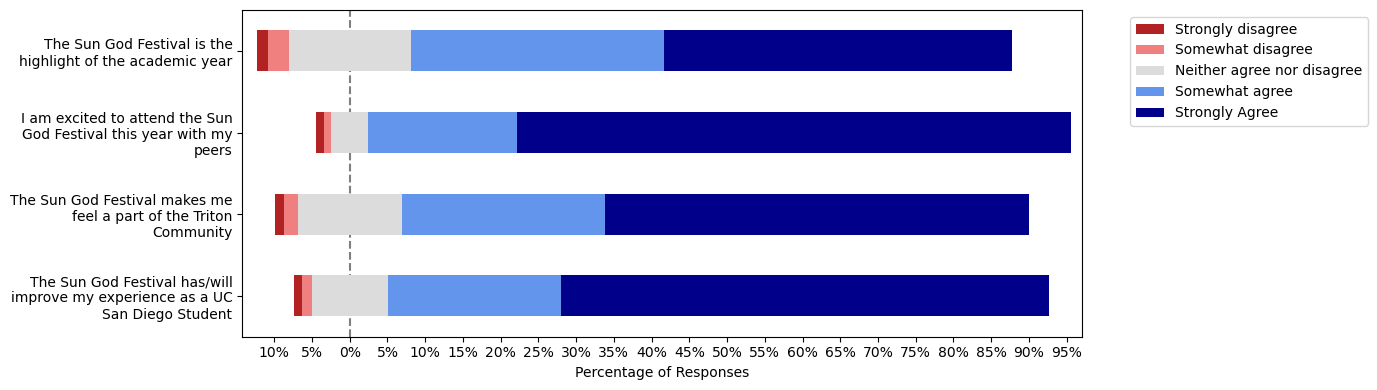

In [11]:
q10data = asce25[['Q10_1', 'Q10_2', 'Q10_3', 'Q10_4']].iloc[2:]
q10data.rename(columns={'Q10_1': 'The Sun God Festival is the highlight of the academic year',
                       'Q10_2': 'I am excited to attend the Sun God Festival this year with my peers',
                       'Q10_3': 'The Sun God Festival makes me feel a part of the Triton Community',
                       'Q10_4': 'The Sun God Festival has/will improve my experience as a UC San Diego Student'}, inplace=True)

# Create a group likert plot based on responses to Sun God Festival sentiment
likert_scale = ['Strongly disagree', 'Somewhat disagree', 'Neither agree nor disagree', 'Somewhat agree','Strongly Agree']
ax = plot_likert.plot_likert(q10data, likert_scale, plot_percentage=True, figsize=(14, 4))
plt.tight_layout()
plt.show()

#### In your own words, how would you describe the Sun God Festival?

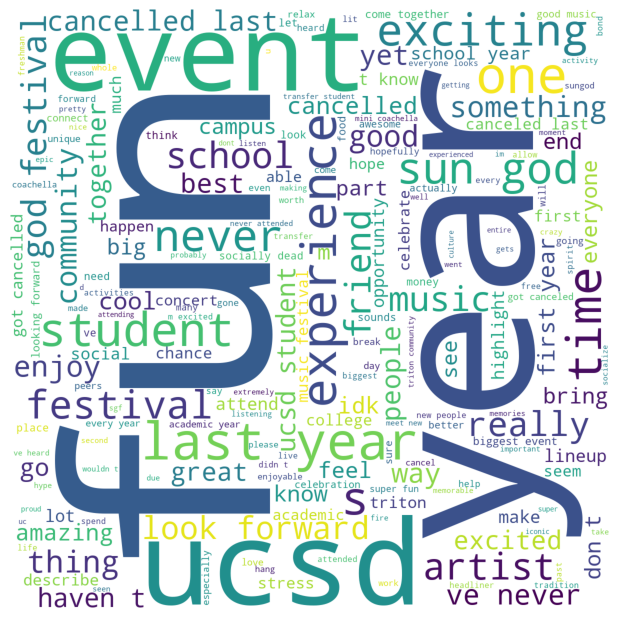

In [12]:
# Remove stop words and tokenize responses
q11data = asce25['Q11.1'].dropna()
comment_words = ''
stopwords = set(STOPWORDS)

for val in q11data:
    val = str(val)
    tokens = val.strip().split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

# Word cloud for how people would describe the Sun God Festival
sgfwordcloud = WordCloud(width=1200, height=1200, background_color='white', stopwords=stopwords, min_font_size=10).generate(comment_words)
              
plt.figure(figsize=(6,6), facecolor=None)
plt.imshow(sgfwordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<Axes: >

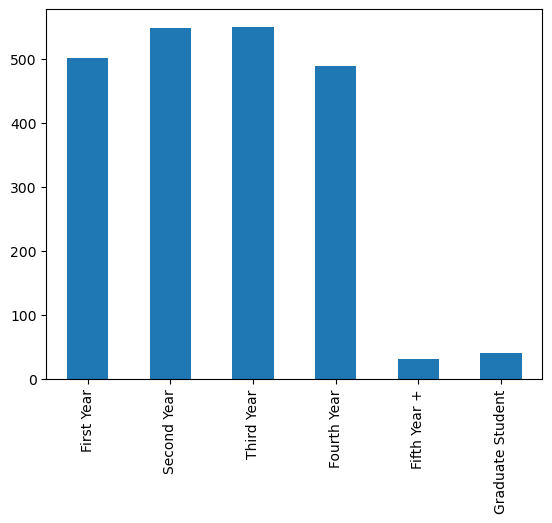

In [13]:
# Distribution of respondents' years
years = ['First Year', 'Second Year', 'Third Year',\
         'Fourth Year', 'Fifth Year +', 'Graduate Student']
mapping = {year: i for i, year in enumerate(years)}

q12data = asce25['Q12'].iloc[2:].map(mapping)
q12data = pd.Categorical(asce25['Q12'].iloc[2:], categories=years, ordered=True)
q12data.value_counts().sort_index().plot(kind='bar')

## Artists Recommended by Students

In [15]:
# Remove accents from responses
def remove_accents(text):
    normalized_text = unicodedata.normalize('NFD', text)
    unaccented_text = ''.join(char for char in normalized_text if unicodedata.category(char) != 'Mn')
    return unaccented_text

# Remove emojis from responses
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        r"!"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

# Collate the 3 recommendations for artists and clean them
artists = pd.concat([
    asce25['Q3_1'].iloc[2:],
    asce25['Q3_2'].iloc[2:],
    asce25['Q3_3'].iloc[2:]
], ignore_index=True).dropna().apply(str.lower).apply(remove_accents).apply(remove_emojis).apply(str.strip).replace(responses_map)

# Store the names and counts of artists recommended
cnts = artists.value_counts().reset_index()
cnts = cnts[cnts['index'] != ""]
cnts.set_index('index', inplace=True)
cnts.to_csv('data/asce25-raw-artists.csv')

In [55]:
# Use client details to get access token from Spotify
def get_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_header = {
        'Authorization': 'Basic ' + base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()
    }
    auth_data = {'grant_type': 'client_credentials'}
    
    response = requests.post(auth_url, headers=auth_header, data=auth_data)
    return response.json().get('access_token')

# Query for artist ID using names off the survey from Spotify
def get_search_artist(artist_name, access_token):
    search_url = 'https://api.spotify.com/v1/search'
    headers = {'Authorization': f'Bearer {access_token}'}
    params = {'q': artist_name, 'type': 'artist', 'limit': 1}
    
    response = requests.get(search_url, headers=headers, params=params)
    artists = response.json().get('artists', {}).get('items', [])
    return artists[0]['id'] if artists else None

# Query for an artist's popularity score using their ID from Spotify
def get_artist_popularity(artist_id, access_token):
    artist_url = f'https://api.spotify.com/v1/artists/{artist_id}'
    headers = {'Authorization': f'Bearer {access_token}'}
    
    response = requests.get(artist_url, headers=headers)
    return response.json().get('popularity')

load_dotenv()
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')
access_token = get_access_token(client_id, client_secret)

In [73]:
formatted = pd.read_csv('data/asce25-artists-count-formatted.csv', index_col='index')
formatted['popularity'] = np.nan

# Query and store each artist's popularity
for artist_name in tqdm(formatted.index):
    cnt = formatted.loc[artist_name]['count']
    
    artist_id = get_search_artist(artist_name, access_token)
    if artist_id:
        popularity = get_artist_popularity(artist_id, access_token)
        formatted.loc[formatted.index == artist_name, 'popularity'] = popularity
    else:
        print(f"Artist {artist_name} not found.")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1388/1388 [10:39<00:00,  2.17it/s]


In [140]:
# Convert JSON from more human readable {'year': ['artists']} format to more practical {'artist': ['years'] format
def get_prev_artists(paths):
    prev_artists = defaultdict(set)
    
    for path in paths:
        with open(path) as prev_artists_file:
            prev_artists_raw = json.load(prev_artists_file)

        for year in prev_artists_raw:
            for artist in prev_artists_raw[year]:
                prev_artists[artist].add(year)
    return prev_artists

prev_artists = get_prev_artists(['data/previous-sgf-artists.json', 'data/previous-misc-artists.json'])

In [244]:
# Clean words from punctuation, accents and casing
def stem_word(x):
    return remove_accents(x.translate(str.maketrans('', '', string.punctuation)).lower()).strip()

# Using Levenshtein distance to fuzzy name match
def find_closest_match(input_name, df_column, threshold=2):
        distances = df_column.apply(lambda x: Levenshtein.distance(stem_word(input_name), x))

        min_distance = distances.min()
        min_distance_index = distances.idxmin()
        closest_match = df_column[min_distance_index]

        if min_distance <= threshold:
            return closest_match, min_distance
        else:
            return None, None

year_buckets_relative = [1, 3, 5, 10, 15, 20, 30]
current_year = datetime.now().year
year_buckets = [current_year-x+1 for x in year_buckets_relative]

stemmed_artists = formatted.copy(deep=True)
stemmed_artists['Stemmed'] = (formatted.index).to_series().apply(stem_word)
stemmed_artists['Year'] = np.nan
stemmed_artists['Most Recent Year'] = "Has not been to UCSD for ASCE"

# Previous mistakes that were matched (they did not come to UCSD)
fuzzy_mistakes = [('i', 'ti'), ('brb', 'bob'), ('junny', 'hunny'), ('ive', 'live')]
found, not_found = [], []

# Add all years and text for the most recent bucket of years an artist has come, if they have come
for artist_name in prev_artists:
    threshold = 1
    closest_match, distance = find_closest_match(artist_name, stemmed_artists['Stemmed'], threshold)

    if closest_match and (stem_word(closest_match), stem_word(artist_name)) not in fuzzy_mistakes:
        recent_year = sorted(prev_artists[artist_name])[-1]
        recent_bucket = next((x[0] for x in enumerate(year_buckets_relative) if x[1] > current_year-int(recent_year)), -1)
        stemmed_artists.loc[stemmed_artists.index == artist_name, 'Most Recent Year'] = \
            f"Last {year_buckets_relative[recent_bucket]} Year{'s' if recent_bucket > 0 else ''}" if recent_bucket != -1 else "Been to UCSD for ASCE"
        stemmed_artists.loc[stemmed_artists.index == artist_name, 'Year'] = ", ".join(sorted(prev_artists[artist_name]))
        
        found.append((artist_name, closest_match))
    else:
        not_found.append(artist_name)

print(found)

[('They Might Be Giants', 'they might be giants'), ('311', '311'), ('Social Distortion', 'social distortion'), ('Black Eyed Peas', 'black eyed peas'), ('My Chemical Romance', 'my chemical romance'), ('Neon Trees', 'neon trees'), ('Drake', 'drake'), ('Jimmy Eat World', 'jimmy eat world'), ('Mike Posner', 'mike posner'), ('Crystal Castles', 'crystal castles'), ('Macklemore', 'macklemore'), ('Tokimonsta', 'tokimonsta'), ('Kendrick Lamar', 'kendrick lamar'), ('Porter Robinson', 'porter robinson'), ('Young the Giant', 'young the giant'), ('Joey Bada$$', 'joey bada'), ('Ty Dolla $ign', 'ty dolla ign'), ('Audien', 'audien'), ('Snoop Dogg', 'snoop dogg'), ('Jhené Aiko', 'jhene aiko'), ('Miguel', 'miguel'), ('Louis the Child', 'louis the child'), ('ScHoolboy Q', 'schoolboy q'), ('Bad Suns', 'bad suns'), ('Khalid', 'khalid'), ('Cuco', 'cuco'), ('Ashe', 'ashe'), ('Vince Staples', 'vince staples'), ('Joji', 'joji'), ('Hayley Kiyoko', 'hayley kiyoko'), ('Gryffin', 'gryffin'), ('Omar Apollo', 'omar 

In [245]:
stemmed_artists

,count,popularity,Stemmed,Year,Most Recent Year
index,,,,,
Laufey,143,85.0,laufey,2023,Last 3 Years
Katseye,135,74.0,katseye,NaN,Has not been to UCSD for ASCE
Beabadoobee,128,82.0,beabadoobee,NaN,Has not been to UCSD for ASCE
Sabrina Carpenter,128,94.0,sabrina carpenter,NaN,Has not been to UCSD for ASCE
Chappell Roan,125,88.0,chappell roan,NaN,Has not been to UCSD for ASCE
...,...,...,...,...,...
Fall Out Boy,1,81.0,fall out boy,NaN,Has not been to UCSD for ASCE
Violent Vera,1,62.0,violent vera,NaN,Has not been to UCSD for ASCE
Meghan Trainor,1,82.0,meghan trainor,NaN,Has not been to UCSD for ASCE


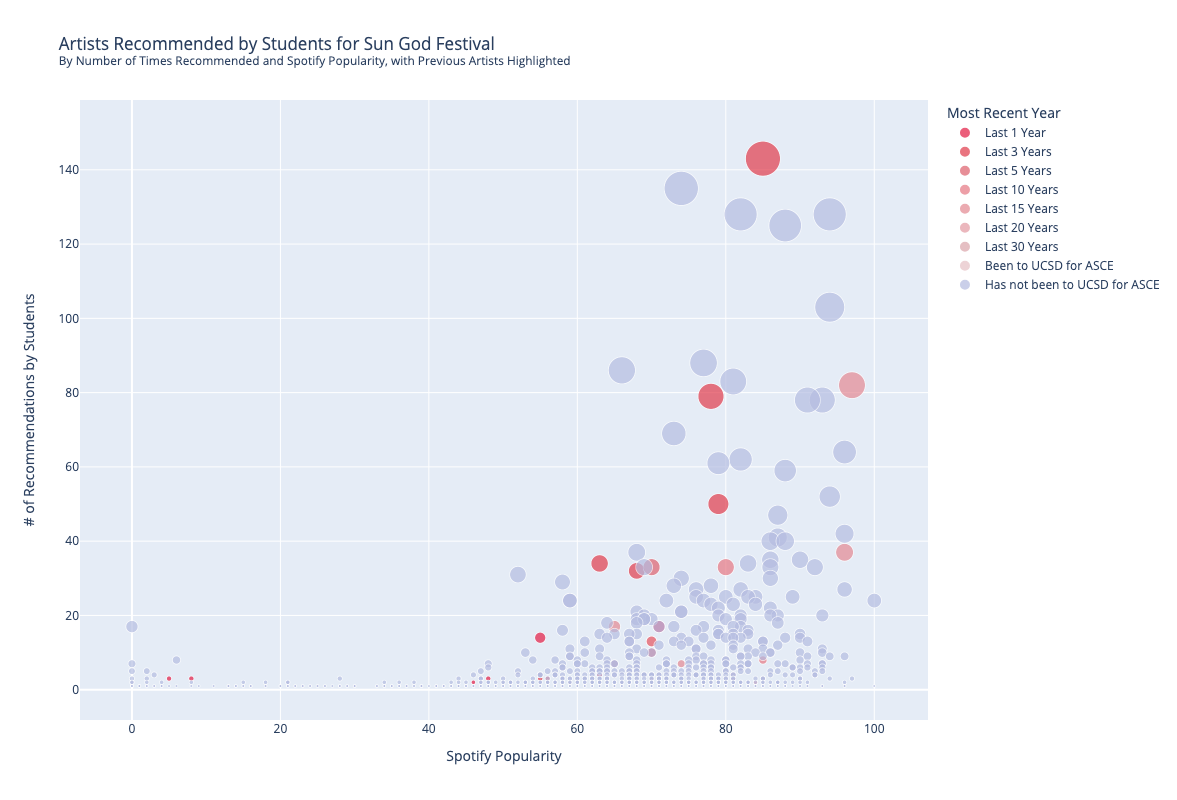

In [349]:
# Gradient based on how recently they've come, or an opposite colour if they haven't
color_map={'Last 1 Year': '#e31b43',
           'Last 3 Years': '#e03a4a',
           'Last 5 Years': '#de5f6c',
           'Last 10 Years': '#e67782',
           'Last 15 Years': '#e38891',
           'Last 20 Years': '#e39aa2',
           'Last 30 Years': '#dba4aa',
           'Been to UCSD for ASCE': '#e6c1c5',
           'Has not been to UCSD for ASCE': '#b4bce0'
          }

stemmed_artists.rename(columns={'count': '# of Recommendations by Students', 'popularity': 'Spotify Popularity'}, inplace=True)
stemmed_artists['Artist Name'] = stemmed_artists.index

fig = px.scatter(stemmed_artists, x="Spotify Popularity", y="# of Recommendations by Students",
                 size="# of Recommendations by Students", color="Most Recent Year",
                 hover_name=formatted.index,
                 size_max=35,
                 height=800, width=1200,
                 custom_data=['Artist Name'],
                 color_discrete_map=color_map,
                 category_orders={'Most Recent Year': year_order},
                 title="Artists Recommended by Students for Sun God Festival<br><sup>By Number of Times Recommended and Spotify Popularity, with Previous Artists Highlighted</sup>",
                )

# Custom tooltip for the bubbles
fig.update_traces(marker=dict(line=dict(color='white', width=0.75)))
fig.update_traces(
    hovertemplate=(
        "<br><b>%{customdata[0]}</b><br>—<br>"
        "%{data.name}<br>"
        "%{y} // Number of Recommendations by Students<br>"
        "%{x} // Spotify Popularity<br><br>"
        "<extra></extra>"
    )
)

# Slight tooltip visual changes
fig.update_layout(
    hoverlabel=dict(
        font=dict(color="#222"),
        bordercolor="white",
    )
)

# Lighten the background colour of each hover label by about half
for trace in fig.data:
    trace_name = trace.name
    if trace_name in color_map:
        rgba = mcolors.to_rgba(color_map[trace_name], alpha=0.5)
        rgb = [str(255*(1-(1-x)/2)) for x in rgba][:3]
        trace.hoverlabel = dict(bgcolor='rgb('+','.join(rgb[:3])+')')
fig.show()